# Project Group - 15

Members: 
Sören Burghardt, 
Sarah Blanc, 
Allan Guzmann, 
Lars van den Berg, 
Simon Schreders

Student numbers: 
5861012, 
5854830, 
5718619,
5626668,
5878845

# Research Objective

What are the effects on aviation that COVID-19  caused at the Amsterdam Schiphol Airport (EHAM) and its most frequented destinations for freight and passenger transport?

When COVID-19 became a global pandemic in 2020, the containments plunged the global economy into an unprecedented recession. The magnitude of the economic shock was such that it resulted in unrecognisable data and a "data fog" that made it difficult to interpret and, more importantly, to predict. The last two years have been extraordinary, both for global economy and the humanity. While the COVID-19 pandemic now appears to be under control thanks to vaccination programmes, parts of the global economy are not yet fully recovered. As a result of the protective travel restrictions, the aviation sector has been hit harder than many others industries. In this project, our aim was to observe the impacts that covid has had on aviation and in particular, the impacts on Amsterdam Schiphol Airport and its most frequented destinations. This from the perspective of passenger and freight transport.

This research question is answered by answering similiar sub-research questions:
1. What is the top 5 of frequent destinations for passenger transport from Amsterdam Schiphol Airport (2019)?
2. What is the top 5 of frequent destinations for freight transport from Amsterdam Schiphol Airport (2019)?
3. What are the volumes of these top 5's in the last 20 years?
4. What is the effect caused by COVID on Amsterdam Schiphol Airport compared to other Dutch airports?
5. What is the effect caused by COVID on other specific airports?
6. Are there other effects caused by COVID (China comparison)?

# Contribution Statement

*Be specific. Some of the tasks can be coding (expect everyone to do this), background research, conceptualisation, visualisation, data analysis, data modelling*

Sören: Background research, coding, 

Sarah: Background research, coding,  

Allan: Background research, coding, 

Lars: Background research, coding, 

Simon: Background research, coding

# Data Used

COVID-19 cases in the world (Our World in Data)

Flight data passengers (Eu Stat)

Flight data freight (EU Stat)

OD Data for Airport Amsterdam (EU Stat)


# Data Pipeline

All the data for flights from Amsterdam Airport Schiphol (EHAM) were grouped by country. This way two top 5 were created for both the volume of cargo and mail and the passangers. The countries from these two top 5's and the Netherlands were used to filter the COVID-19 cases, using the amount of confirmed new cases per million in a country. 

As a first step, we are going to import all the librairies that we will need.

In [2]:
import pandas as pd
import numpy as np
import plotly as plt

import math
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import geopandas as gpd

import plotly.io as pio
import plotly.graph_objects as go   
import country_converter as coco

import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

# Part I - Data import

First, we are going to import the dataframes. We are going to modifiy them in order to prepare them for our project and to combine them together. 

We are starting with the flight-data, we have modified them according to our needs. 

In [ ]:
# Import datasets
freight = pd.read_csv("Data_Sets/avia_gor_nl__custom_3564729_monthly_linear.csv")
passengers = pd.read_csv("Data_Sets/avia_par_nl__custom_3564728_monthly_linear.csv")

# Setting up special cleaning list
country_code_fix = {'EL':'GR','AN':'BQ'}

def top_n_year(df,n,year):
    # This function has a dataframe, a number of entries and a year as inputs and 
    # as output the dataframe filtered for the top n countries on a specific year
    df[["airp_country_1","airp_code_1","airp_country_2","airp_code_2"]] = df.airp_pr.str.split("_",expand=True)
    df[["Year","Month"]] = df.TIME_PERIOD.str.split("-",expand=True)
    topn = df.groupby(['Year',"airp_country_2"]).sum()
    topn = topn.loc[year,:].sort_values("OBS_VALUE", ascending= False).head(n).reset_index()
    cleaned = df[df["airp_country_2"].isin(topn["airp_country_2"])]
    return cleaned

def codes_correction(df,ISO_2):
    # This function has a data frame and a ISO2 countries list and outputs the same 
    # dataframe adding a ISO3 code and the country name for each unique
    df[ISO_2] = df[ISO_2].replace(to_replace= country_code_fix)
    df['iso_3_country'] = coco.convert(names = df[ISO_2], to= 'ISO3')
    df['country_2_name'] = coco.convert(names = df[ISO_2], to= 'name_short')
    return df

# Call defined functions for the 2 datasets
top_passengers = top_n_year(passengers,5,'2019')
top_cargo = top_n_year(freight,5,'2019')

Explain code below

In [ ]:
# importing the world geometry data from geopandas library
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

In [ ]:
#COVID PART 
filepath = 'Data_Sets/owid-covid-data.csv'
covid_data = pd.read_csv(filepath, delimiter=',')

# Select the columns of interest from the original dataset and filter it, also expand the date to accomodate year and month
columns_of_interest = ['new_cases_smoothed_per_million','people_fully_vaccinated_per_hundred','date','location']
filtered_covid_data = covid_data[columns_of_interest]
filtered_covid_data[['Year','Month','Day']] = filtered_covid_data.date.str.split("-",expand=True)

# Selecting the countries of interest for cargo and passenger transport
cargo_countries_of_interest =['China','United States','United Arab Emirates','Brazil','Qatar','Netherlands']
passenger_countries_of_interest = ['United Kingdom','Spain','Germany','Italy','United States','Netherlands']

# Group by year, month and location to calculate the mean for cargo transport
cargo_filtered_covid_data = filtered_covid_data[filtered_covid_data['location'].isin(cargo_countries_of_interest)]
cargo_filtered_covid_data = cargo_filtered_covid_data.groupby(['location','Year','Month']).mean()

# Resetting the index and creating new collum with Year and Month 
cargo_filtered_covid_data = cargo_filtered_covid_data.reset_index()
cargo_filtered_covid_data['date'] = cargo_filtered_covid_data['Year'] + ['-'] + cargo_filtered_covid_data['Month'] 

# Group by year, month and location to calculate the mean for cargo transport
passenger_filtered_covid_data = filtered_covid_data[filtered_covid_data['location'].isin(passenger_countries_of_interest)]
passenger_filtered_covid_data = passenger_filtered_covid_data.groupby(['location','Year','Month']).mean()

#Resetting the index and creating new collum with Year and Month 
passenger_filtered_covid_data = passenger_filtered_covid_data.reset_index()
passenger_filtered_covid_data['date'] = passenger_filtered_covid_data['Year'] + ['-'] + passenger_filtered_covid_data['Month']

# Part II - Data Processing

In the code below we combined the information for passengers flying from Amsterdam Schiphol Airport. > Some more analysis

In [ ]:
passengers_for_map = passengers.groupby(['Year','airp_country_2']).sum()
passengers_for_map = passengers_for_map.loc['2019',:].reset_index()
passengers_for_map = codes_correction(passengers_for_map,'airp_country_2')

freight_for_map = freight.groupby(['Year','airp_country_2']).sum()
freight_for_map = freight_for_map.loc['2019',:].reset_index()
freight_for_map = codes_correction(freight_for_map,'airp_country_2')


In [ ]:
passenger_labels = {
    'OBS_VALUE':'Total passengers (passengers)',
    'country_2_name': 'Country',
    'iso_3_country': 'Country code'
}
cargo_labels = {
    'country_2_name':'Country',
    'OBS_VALUE': 'Total cargo [tons]',
    'iso_3_country': 'Country code'
}

In [ ]:
map_data_passengers = world.merge(passengers_for_map,left_on = 'iso_a3', right_on = 'iso_3_country', how = 'left')

fig = px.choropleth(map_data_passengers, hover_name = 'country_2_name',locations= 'iso_3_country', \
    locationmode= 'ISO-3', color='OBS_VALUE',labels = passenger_labels)

fig.update_layout(
    title_text = 'Total passengers flying from Schiphol Airport in 2019',
    coloraxis_colorbar_title_text = 'Total passengers',
    geo= dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    )
)
fig.show()

In [ ]:
passenger_labels = {
    'OBS_VALUE':'Total passengers (passengers)',
    'country_2_name': 'Country'
}

fig = px.bar(map_data_passengers.sort_values('OBS_VALUE',ascending= False).head(20),\
    x= 'country_2_name', y = 'OBS_VALUE',labels=passenger_labels)

fig.update_layout(
    title_text = 'Total passengers transported by air from Schiphol Airport in 2019',
    
)
fig.show()

After this information we made a top 5 of countries for passengers. Here you can see the historical data of the top 5. COVID is clearly visible.

In [ ]:
total_passengers = top_passengers.groupby(['airp_country_2','Year']).sum()
total_passengers = total_passengers.reset_index()
total_passengers = codes_correction(total_passengers,'airp_country_2')
fig = px.line(total_passengers, x='Year', y= 'OBS_VALUE' ,color='airp_country_2',labels= passenger_labels)
fig.show()

Repeat the same for cargo transported on planes.

In [ ]:
map_data_cargo = world.merge(freight_for_map,left_on = 'iso_a3', right_on = 'iso_3_country', how = 'left')

fig = px.choropleth(freight_for_map, hover_name = 'country_2_name',locations= 'iso_3_country', \
    locationmode= 'ISO-3', color='OBS_VALUE',labels = cargo_labels)

fig.update_layout(
    title_text = 'Total tons transported by air from Schiphol Airport in 2019',
    geo= dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    )
)
fig.show()

In [ ]:
fig = px.bar(map_data_cargo.sort_values('OBS_VALUE',ascending= False).head(20),\
    x= 'country_2_name', y = 'OBS_VALUE',labels= cargo_labels)
fig.update_layout(
    title_text = 'Total tons transported by air from Schiphol Airport in 2019',
    geo= dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    )
)
fig.show()

In [ ]:
total_cargo = top_cargo.groupby(['airp_country_2','Year']).sum()
total_cargo = total_cargo.reset_index()
total_cargo = codes_correction(total_cargo,'airp_country_2')
fig = px.line(total_cargo, x='Year', y= 'OBS_VALUE' ,color='airp_country_2',labels=cargo_labels)
fig.show()

Then we start the COVID-19 data of all we decided to keep only the columns we needed to avoid having unused information in this data frame. We filtered this new data frame and expanded the date to the accomodate year and month. The COVID-19 data is only imported for the countries of interest (the two top 5's and the Netherlands).

In parallel, let's look at the evolution of covid cases since the beginning of the pandemic and the vaccination rate in the Netherlands.

In [ ]:
fig = px.line(passenger_filtered_covid_data, x='date', y= 'new_cases_smoothed_per_million' ,color='location',
                title= 'New covid cases in the top 5 countries for passenger transport', labels={
                     'new_cases_smoothed_per_million': 'covid cases per million',
                     'date' : 'Date'})

fig.show()

In [ ]:
fig = px.line(cargo_filtered_covid_data, x='date', y= 'new_cases_smoothed_per_million' ,color='location',
              title= 'New covid cases in the top 5 countries for cargo transport', range_y=[0,2000] )

fig.show()

In [ ]:
fig = px.line(passenger_filtered_covid_data, x='date', y= 'people_fully_vaccinated_per_hundred' ,color='location',
               title= 'Vaccination rate in percent in the top 5 countries for passenger transport' )

fig.show()

In [ ]:
fig = px.line(cargo_filtered_covid_data, x='date', y= 'people_fully_vaccinated_per_hundred' ,color='location',
                title= 'Vaccination rate in percent in the top 5 countries for cargo transport')

fig.show()

# Part 3 - Data Visualisation

This part 3 is divided into two sub-questions. Firstly, we will answer the question "Are there other effects caused by COVID (China comparison)?". Then, in order to finish this report, we will consider the question "What is the effect caused by COVID on Amsterdam Schiphol Airport compared to other Dutch airports?".

While discussing the first research question we noticed that, even though is has been proven that COVID-19 arised in China, the amount of COVID cases are very low. We decided to investige this futher. For the first part of the visualisation, we decided to compare the impact on the transport sector of the start of Covid in the Netherlands and in China. In this way, it will be possible to compare the two situations in order to understand whether the Chinese have really been able to escape Covid and its impacts or not. Indeed, as their number of cases is officially so low, it would be possible to think that their economy has not been impacted. But is this really the case? What were the influences of the covid on the country compared to the Netherlands? We decided to proceed as follows:
- First, we will compare the purely covid-related data between the two countries.
- Then, we will analyse the behaviour of the transport economy in China in order to compare it to that of the Netherlands.

Quantities cannot be compared as such. After all, China is one of the world's largest powers, which is in no way comparable with the Netherlands. However, it is possible to compare the trend of the different curves when the first wave of Covid appeared (increasing, decreasing, stagnating).

Import and preparation of the covid data

In [16]:
filepath = 'Data_Sets/owid-covid-data.csv'
covid_data = pd.read_csv(filepath, delimiter=',')

# Select the columns of interest from the original dataset and filter it, also expand the date to accomodate year and month
columns_of_interest = ['new_cases_smoothed_per_million','people_fully_vaccinated_per_hundred','date','location']
filtered_covid_data = covid_data[columns_of_interest]
filtered_covid_data[['Year','Month','Day']] = filtered_covid_data.date.str.split("-",expand=True)
filtered_covid_data.head()
#Select the countrys of interest 
Covid_China = filtered_covid_data[filtered_covid_data['location'].isin(['Netherlands','China'])]
Covid_China.head(-5)



/var/folders/d3/q8jsq7p56m12h2f2lx6k5wl80000gn/T/ipykernel_3167/3256786670.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/d3/q8jsq7p56m12h2f2lx6k5wl80000gn/T/ipykernel_3167/3256786670.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/d3/q8jsq7p56m12h2f2lx6k5wl80000gn/T/ipykernel_3167/3256786670.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

,new_cases_smoothed_per_million,people_fully_vaccinated_per_hundred,date,location,Year,Month,Day
40988,NaN,NaN,2020-01-22,China,2020,01,22
40989,NaN,NaN,2020-01-23,China,2020,01,23
40990,NaN,NaN,2020-01-24,China,2020,01,24
40991,NaN,NaN,2020-01-25,China,2020,01,25
40992,NaN,NaN,2020-01-26,China,2020,01,26
...,...,...,...,...,...,...,...
141454,125.751,NaN,2022-10-02,Netherlands,2022,10,02
141455,125.735,NaN,2022-10-03,Netherlands,2022,10,03
141456,155.209,NaN,2022-10-04,Netherlands,2022,10,04
141457,155.209,NaN,2022-10-05,Netherlands,2022,10,05


Import and preparation of the transportation data (for China and the Netherlands)

1. Air passengers carried include both domestic and international aircraft passengers of air carriers registered in the country.

In [17]:
# Import of the data
filepath1 = 'Data_Sets/Passengers.csv'
Passengers = pd.read_csv(filepath1, delimiter=',')
# Unuseful columns are removed
Passengers_drop = Passengers.drop(['Country Code', 'Indicator Name', 'Indicator Code'],  axis=1)
Passengers_drop.set_index('Country', inplace=True) 
Passengers_wanted = Passengers_drop.T
# Selection of the wanted data
China_passengers_final = Passengers_wanted.China.reset_index()
China_passengers_final.columns = ['Year', 'Number of passengers carried, China']
NL_passengers_final = Passengers_wanted.Netherlands.reset_index()
NL_passengers_final.columns = ['Year', 'Number of passengers carried, NL']


2. Air freight is the volume of freight, express, and diplomatic bags carried on each flight stage (operation of an aircraft from takeoff to its next landing), measured in metric tons times kilometers traveled.

In [18]:
# Import of the data
filepath2 = 'Data_Sets/Freight.csv'
Freight = pd.read_csv(filepath2, delimiter=',')
# Unuseful columns are removed
Freight_drop = Freight.drop(['Country Code', 'Indicator Name', 'Indicator Code'],  axis=1)
Freight_drop.set_index('Country Name', inplace=True) 
Freight_wanted = Freight_drop.T
# Selection of the wanted data
NL_freight_final = Freight_wanted.Netherlands.reset_index()
NL_freight_final.columns = ['Year', 'Volume of freight carried, NL']
China_freight_final = Freight_wanted.China.reset_index()
China_freight_final.columns = ['Year', 'Volume of freight carried, China']

3. Port container traffic measures the flow of containers from land to sea transport modes, and vice versa, in twenty-foot equivalent units (TEUs), a standard-size container. Data refer to coastal shipping as well as international journeys. Transshipment traffic is counted as two lifts at the intermediate port (once to off-load and again as an outbound lift) and includes empty units.

In [19]:
# Import of the data
filepath3 = 'Data_Sets/Container.csv'
Container = pd.read_csv(filepath3, delimiter=',')
# Unuseful columns are removed
Container_drop = Container.drop(['Country Code', 'Indicator Name', 'Indicator Code'],  axis=1)
Container_drop.set_index('Country Name', inplace=True) 
Container_wanted = Container_drop.T
# Selection of the wanted data
China_container_final = Container_wanted.China.reset_index()
China_container_final.columns = ['Year', 'Flow of containers carried, China']
NL_container_final = Container_wanted.Netherlands.reset_index()
NL_container_final.columns = ['Year', 'Flow of containers carried, NL']

4. Carbon dioxide emissions are those stemming from the burning of fossil fuels and the manufacture of cement. They include carbon dioxide produced during consumption of solid, liquid, and gas fuels and gas flaring.

In [20]:
# Import of the data
filepath4 = 'Data_Sets/CO2_emissions.csv'
CO2 = pd.read_csv(filepath4, delimiter=',')
# Unuseful columns are removed
CO2_drop = CO2.drop(['Country Code', 'Indicator Name', 'Indicator Code'],  axis=1)
CO2_drop.set_index('Country Name', inplace=True) 
CO2_wanted = CO2_drop.T
# Selection of the wanted data
NL_CO2_final = CO2_wanted.Netherlands.reset_index()
NL_CO2_final.columns = ['Year', 'Carbon dioxide emissions, NL']
China_CO2_final = CO2_wanted.China.reset_index()
China_CO2_final.columns = ['Year', 'Carbon dioxide emissions, China']


5. Life expectancy at birth indicates the number of years a newborn infant would live if prevailing patterns of mortality at the time of its birth were to stay the same throughout its life.

In [21]:
# Import of the data
filepath5 = 'Data_Sets/Lifeexp.csv'
Lifeexp = pd.read_csv(filepath5, delimiter=',')
# Unuseful columns are removed
Lifeexp_drop = Lifeexp.drop(['Country Code', 'Indicator Name', 'Indicator Code'],  axis=1)
Lifeexp_drop.set_index('Country Name', inplace=True) 
Lifeexp_wanted = Lifeexp_drop.T
# Selection of the wanted data
NL_Lifeexp_final = Lifeexp_wanted.Netherlands.reset_index()
NL_Lifeexp_final.columns = ['Year', 'Life expectancy, NL']
China_Lifeexp_final = Lifeexp_wanted.China.reset_index()
China_Lifeexp_final.columns = ['Year', 'Life expectancy, China']

6. Annual percentage growth rate of GDP at market prices based on constant local currency. Aggregates are based on constant 2015 prices, expressed in U.S. dollars. GDP is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources.

In [22]:
# Import of the data
filepath6 = 'Data_Sets/GDP.csv'
GPD = pd.read_csv(filepath6, delimiter=',')
# Unuseful columns are removed
GPD_drop = GPD.drop(['Country Code', 'Indicator Name', 'Indicator Code'],  axis=1)
GPD_drop.set_index('Country Name', inplace=True) 
GPD_wanted = GPD_drop.T
# Selection of the wanted data
NL_GPD_final = GPD_wanted.Netherlands.reset_index()
NL_GPD_final.columns = ['Year', 'GDP growth, NL']
China_GPD_final = GPD_wanted.China.reset_index()
China_GPD_final.columns = ['Year', 'GDP growth, China']

Join of all data frames on the column 'date' to two dataframes

In [23]:
#Merging the data on the column 'Year'
df1 = pd.merge(NL_passengers_final, China_passengers_final, how='outer', on='Year')
df1 = pd.merge(df1, NL_freight_final, how='outer', on='Year')
df1 = pd.merge(df1, China_freight_final, how='outer', on='Year')
df1 = pd.merge(df1, NL_container_final, how='outer', on='Year')
df1 = pd.merge(df1, China_container_final, how='outer', on='Year')
df1 = pd.merge(df1, NL_CO2_final, how='outer', on='Year')
df1 = pd.merge(df1, China_CO2_final, how='outer', on='Year')
df2 = pd.merge(China_Lifeexp_final, NL_Lifeexp_final, how='outer', on='Year')
df2 = pd.merge(df2, NL_GPD_final, how='outer', on='Year')
df2 = pd.merge(df2, China_GPD_final, how='outer', on='Year')
df1 = df1.iloc[ 0:61, : ]
df2 = df2.iloc[ 0:61, : ]
df1

,Year,"Number of passengers carried, NL","Number of passengers carried, China","Volume of freight carried, NL","Volume of freight carried, China","Flow of containers carried, NL","Flow of containers carried, China","Carbon dioxide emissions, NL","Carbon dioxide emissions, China"
0,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
56,2016,40078714.00,487960477.0,4745.958515,21304.5851,12556000.0,197849000.0,9.309282,7.115385
57,2017,42763443.00,551234509.0,5855.480476,23323.6147,13911000.0,222155820.0,9.092131,7.230985
58,2018,44417573.58,611439830.0,5886.514904,25256.2071,14696000.0,233201600.0,8.783850,7.487332
59,2019,46358457.95,659629070.0,5656.442000,25394.5878,14986800.0,242030000.0,8.437075,7.605937


1. Let's first analyse and compare the covid data. 

In [38]:
#Interactive plot (color makes possible to select on right of graph)
fig = px.line(Covid_China, x='date', y= 'new_cases_smoothed_per_million' ,color='location',
title= 'New covid cases smoothed per million in the Netherlands and in China',
 labels={
                   #Change label names
                   'new_cases_smoothed_per_million': 'New covid cases smoothed per million',
                   'date': 'Date'
               }, ) 

# Add annotations of important moments
fig.add_annotation(x='2020-11-03', y=490, ax='2020-10-29', ay=3000, text='Increase Lockdown',
                    xref='x', yref='y', axref='x', ayref='y')

fig.add_annotation(x='2020-12-14', y=513, ax='2021-01-01', ay=2000, text='Full Lockdown',
                    xref='x', yref='y', axref='x', ayref='y')

fig.add_annotation(x='2021-12-20', y=746, ax='2021-11-25', ay=2500, text='Full Lockdown',
                    xref='x', yref='y', axref='x', ayref='y')

#Show the graph
fig.show()

As the graph above shows, China has indeed recorded very few cases. The Netherlands, on the other hand, has a curve that is dictated by the different epidemic waves. China's curve even seems to be constantly zero. However, they did consider some cases as shown below:

In [25]:
#Interactive plot (color makes possible to select on right of graph)
fig = px.line(Covid_China, x='date', y= 'new_cases_smoothed_per_million' ,color='location',
                range_x= ['2020-01-22', '2020-03-31'], range_y=[0,60], title= 'New covid cases smoothed per million in the Netherlands and in China between January and March 2020',
                 labels={
                   #Change label names
                   'new_cases_smoothed_per_million': 'New covid cases smoothed per million',
                   'date': 'Date'
               }, ) 

#Show the graph
fig.show()

This period is the very beginning of the pandemic. The Netherlands had not even started to register casesHowever, the number of cases remains relatively low compared to the large population of China.

In [26]:
#Interactive plot (color makes possible to select on right of graph)
fig = px.line(Covid_China, x='date', y= 'new_cases_smoothed_per_million' ,color='location',
                range_x= ['2022-04-01', '2022-05-31'], range_y=[0,200], title = 'New covid cases smoothed per million in the Netherlands and in China between April and May 2022',
                labels={
                   #Change label names
                   'new_cases_smoothed_per_million': 'New covid cases smoothed per million',
                   'date': 'Date'
               }, ) 

#Show the graph
fig.show()

As can be seen above, a tiny peak in covid can also be seen in April 2022.

It is interesting to compare the vaccination rate of the population.

In [27]:
#Interactive plot (color makes possible to select on right of graph)
fig = px.line(Covid_China, x='date', y= 'people_fully_vaccinated_per_hundred' ,color='location',
               title= 'Vaccination rate in percent in the Netherlands and in China',
                labels={
                   #Change label names
                   'people_fully_vaccinated_per_hundred': 'People fully vaccinated [%]',
                   'date': 'Date'
               }, ) 

#Show the graph
fig.show()

In [28]:
#Interactive plot (color makes possible to select on right of graph)
fig = px.line(df1, x='Year', y= ['Number of passengers carried, NL', 'Number of passengers carried, China'], title = 'Number of passengers carried',
                labels={
                   #Change label name
                   'value': 'Number of passengers carried'

               }, ) 

#Show the graph
fig.show()

In [29]:
#Interactive plot (color makes possible to select on right of graph)
fig = px.line(df1, x='Year', y= ['Volume of freight carried, NL', 'Volume of freight carried, China'], title = 'Volume of freight carried (in metric tons times kilometers traveled)',
                labels={
                   #Change label name
                   'value': 'Volume of freight carried'

               }, ) 

#Show the graph
fig.show()

In [30]:
#Interactive plot (color makes possible to select on right of graph)
fig = px.line(df1, x='Year', y= ['Flow of containers carried, NL', 'Flow of containers carried, China'], title = 'Flow of containers carried (in twenty-foot equivalent units (TEUs))',
                labels={
                   #Change label name
                   'value': 'Flow of containers carried'

               }, ) 

#Show the graph
fig.show()

In [31]:
#Interactive plot (color makes possible to select on right of graph)
fig = px.line(df1, x='Year', y= ['Carbon dioxide emissions, NL', 'Carbon dioxide emissions, China'], title = 'Carbon dioxide emissions',
                labels={
                   #Change label name
                   'value': 'Carbon dioxide emissions'

               }, ) 

#Show the graph
fig.show()

In [32]:
#Interactive plot (color makes possible to select on right of graph)
fig = px.line(df2, x='Year', y= ['Life expectancy, NL', 'Life expectancy, China'], title = 'Life expectancy',
                labels={
                   #Change label name
                   'value': 'Life expectancy'

               }, ) 

#Show the graph
fig.show()

In [33]:
#Interactive plot (color makes possible to select on right of graph)
fig = px.line(df2, x='Year', y= ['GDP growth, NL', 'GDP growth, China'],  title = 'GDP growth',
                labels={
                   #Change label name
                   'value': 'GDP growth'

               }, ) 

#Show the graph
fig.show()

All these graphs allow us to make several observations: 


- With regard to the number of passengers carried, both countries observe a decline when the covid pandemic begins in 2019. It is remarkable that China is experiencing an even greater decline than the Netherlands.

- Regarding the volume of freight carried, it comes to the same conclusion. Both countries observe a decline when the covid pandemic begins in 2019. It is also remarkable that China is experiencing an even greater decline than the Netherlands.

- Flow of containers carried ???

- China's carbon dioxid emissions are on the rise. The appearance of covid has not changed this. In contrast, the Netherlands was already in a phase of decreasing CO2 emissions and the introduction of covid has not changed this trend.

- Life expectancy is falling for the Netherlands. This is due to the additional deaths caused by covid. For China, life expectancy continues to increase in 2019. This is consistent with the low number of covid cases and therefore few (very few) covid deaths.

- Both GDPs has descreased with the covid's introduction. The decrease is somewhat greater for the Netherlands.


Although they have very few cases of Covid, China has generally experienced the same consequences of Covid as the Netherlands. Their economy and the behaviour of the different transport variables are in most cases similar to the behaviour observed in the Netherlands.

To go a step further, it is possible to use the Pearson correlation to better understand the dependencies between the different variables. 

<AxesSubplot:>

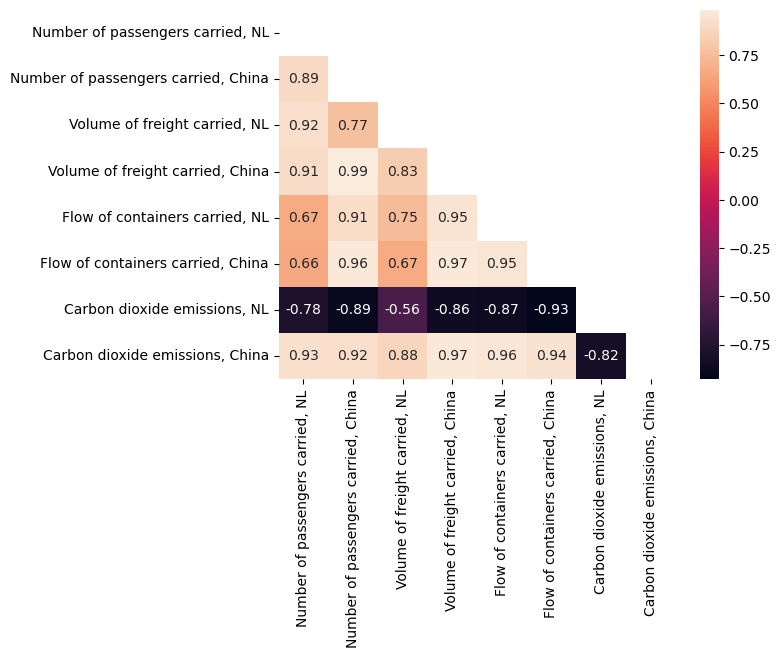

In [34]:
mask = np.triu(np.ones_like(df1.corr(), dtype=bool))
sns.heatmap(df1.corr(), mask=mask, annot=True)  #annot=True

The first observation is that Dutch CO2 emissions are negatively related to other variables. Indeed, the curve is descending while the others are generally ascending. The rest of the variables are positively correlated and are relatively close to 1. This means that they tend to be dependent (the smallest positive value is 0.66).

To answer the second sub-question of this part 3, we collected data from the 5 Dutch airports: Amsterdam Airport Schipol, Rotterdam The Hague Airport, Eindhoven Airport, Maastricht Aachen Airport and Groningen Airport Eeide. The question is whether covid has had the same influence at Schipol as at the other four Dutch airports.

In [10]:
#Import of the data
filepath = 'Data_Sets/Dutch Airports.csv'
DutchAirports = pd.read_csv(filepath, delimiter=';')

#Construction of the wanted data frame by manipulating the original data frame
DutchAirports = DutchAirports.drop(['Aircraft movements/Cross-country flights (number)', 'Aircraft movements/Local flights (number)', 'Commercial air traffic/Flights/All flights/Scheduled (number)'], axis = 1)
DutchAirports = DutchAirports.set_index('Airports')
DutchAirports = DutchAirports.T
DutchAirports = DutchAirports.drop(['Total Dutch airports'], axis = 1)
DutchAirports = DutchAirports.T
DutchAirports = DutchAirports.reset_index()
DutchAirports = DutchAirports.set_index('Periods')
DutchAirports = DutchAirports.T
DutchAirports = DutchAirports.drop(['2018'], axis = 1)
DutchAirports = DutchAirports.drop(['2019'], axis = 1)
DutchAirports = DutchAirports.drop(['2020*'], axis = 1)
DutchAirports = DutchAirports.drop(['2021*'], axis = 1)
DutchAirports = DutchAirports.T
DutchAirports = DutchAirports.reset_index()
#Creating 4 new columns with the purcentage of change from one year to the next one
DutchAirports['PC_flights'] = DutchAirports['Commercial air traffic/Flights/All flights/Total flights (number)'].pct_change()*100
DutchAirports['PC_pass'] = DutchAirports['Commercial air traffic/Passengers/Total passengers/Total passengers (number)'].pct_change()*100
DutchAirports['PC_cargo'] = DutchAirports['Commercial air traffic/Cargo/Total cargo/Total cargo (ton)'].pct_change()*100
DutchAirports['PC_mail'] = DutchAirports['Commercial air traffic/Mail/Total mail/Total mail (ton)'].pct_change()*100
#Remplace all the NA value with zeros
DutchAirports = DutchAirports.fillna(0)

#Show the frame
DutchAirports

,Periods,Airports,Commercial air traffic/Flights/All flights/Total flights (number),Commercial air traffic/Passengers/Total passengers/Total passengers (number),Commercial air traffic/Cargo/Total cargo/Total cargo (ton),Commercial air traffic/Mail/Total mail/Total mail (ton),PC_flights,PC_pass,PC_cargo,PC_mail
0,2020 January*,Amsterdam Airport Schiphol,37567,5074773,113080,1908,0.000000,0.000000,0.000000,0.000000
1,2020 February*,Amsterdam Airport Schiphol,34979,4719769,116293,1491,-6.889025,-6.995466,2.841351,-21.855346
2,2020 March*,Amsterdam Airport Schiphol,25155,2476372,120481,1167,-28.085423,-47.531924,3.601249,-21.730382
3,2020 April*,Amsterdam Airport Schiphol,4236,126015,93255,382,-83.160405,-94.911306,-22.597754,-67.266495
4,2020 May*,Amsterdam Airport Schiphol,5873,207827,104745,542,38.644948,64.922430,12.321055,41.884817
...,...,...,...,...,...,...,...,...,...,...
155,2022 April*,Groningen Airport Eelde,62,5010,0,0,-1.587302,51.542650,0.000000,0.000000
156,2022 May*,Groningen Airport Eelde,120,8746,0,0,93.548387,74.570858,0.000000,0.000000
157,2022 June*,Groningen Airport Eelde,148,9400,0,0,23.333333,7.477704,0.000000,0.000000
158,2022 July*,Groningen Airport Eelde,132,11314,0,0,-10.810811,20.361702,0.000000,0.000000


First, let's visualize the differences in the number of air traffic flights. As the quantities are not at all the same (much more flights in Schipol than in the other airports), it seems more relevant to compare the percentages of change from one month to another in each airport.

In [41]:
#Interactive plot (color makes possible to select on right of graph)
fig = px.line(DutchAirports, x='Periods', y= 'PC_flights', color='Airports', title= 'Percentage of variation in the number of commercial air traffic flights',
                 labels={
                   #Change label names
                   'PC_flights': 'Variation [%]',
                   'Periods': 'Date'
               }, )

#Add range selector to zoom in on periods in Y axis.
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     step="month",
                     stepmode="backward"),
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
    )
)

#Show the graph
fig.show()

It is also possible to visualise the same results in a more dynamic way:

In [12]:
#Dynamic plot
fig = px.bar(DutchAirports, x='PC_flights', y= 'Airports', color='Airports', animation_frame='Periods', 
                 animation_group='Airports', orientation='h', title= 'Percentage of variation in the number of commercial air traffic flights',
                 labels={
                   #Change label names
                   'PC_flights': 'Variation [%]',
                   'Periods': 'Date',
               }, ) 

fig.update_layout(showlegend=False,xaxis_range = [-100,800])
                 
#Show the graph
fig.show()

Then, let's visualize the differences in the number of commercial air traffic passengers, the commercial air traffic cargo and the commercial air traffic mail.

In [40]:
#Interactive plot (color makes possible to select on right of graph)
fig = px.line(DutchAirports, x='Periods', y= 'Commercial air traffic/Passengers/Total passengers/Total passengers (number)' ,color='Airports', title= 'Commercial air traffic passengers',
                 labels={
                   #Change label names
                   'Commercial air traffic/Passengers/Total passengers/Total passengers (number)': 'Number of commercial air traffic passengers',
                   'Periods': 'Date',
               }, )

#Add range selector to zoom in on periods in Y axis.
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     step="month",
                     stepmode="backward"),
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
    )
)
                 

#Show the graph
fig.show()

In [14]:
#Interactive plot (color makes possible to select on right of graph)
fig = px.line(DutchAirports, x='Periods', y= 'Commercial air traffic/Cargo/Total cargo/Total cargo (ton)' ,color='Airports', title= 'Commercial air traffic cargo [ton]',
                 labels={
                   #Change label names
                   'Commercial air traffic/Cargo/Total cargo/Total cargo (ton)': 'Commercial air traffic cargo [ton]',
                   'Periods': 'Date',
               }, 
                 )

#Add range selector to zoom in on periods in Y axis.
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     step="month",
                     stepmode="backward"),
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
    )
)

#Show the graph
fig.show()

In [15]:
#Interactive plot (color makes possible to select on right of graph: practical to zoom on the smaller airports)
fig = px.line(DutchAirports, x='Periods', y= 'Commercial air traffic/Mail/Total mail/Total mail (ton)' ,color='Airports', title= 'Commercial air traffic mail [ton]',
                 labels={
                   #Change label names
                   'Commercial air traffic/Mail/Total mail/Total mail (ton)': 'Commercial air traffic mail [ton]',
                   'Periods': 'Date',
               }, 
                 )

#Add range selector to zoom in on periods in Y axis.
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     step="month",
                     stepmode="backward"),
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
    )
)

#Show the graph
fig.show()

This graph shows that Schipol is the only airport in the Netherlands where mails transit. This graph is therefore less interesting for answering the sub-question. However, it does provide some interesting information.

From all these visualisations we can conclude that, in general, all airports in the Netherlands have suffered the same consequences from Covid. By going into more detail in each of the visualisations:
- Regarding the number of commercial air flights, increases can be observed during the summer periods due to the recovery of air traffic and the abandonment of the strict restrictive measures. It can be seen that the curves have generally the same shape and therefore the same trends.
- For commercial air flight passengers, the curves also have the same shapes. They follow the different waves of the epidemic and the different restrictive measures used to control the covid 19 epidemic. It is interesting to remove the airports with the largest numbers from the graph (by selecting them in the legend on the right hand side) each time in order to zoom in on the smaller airports. By doing this, it is clear that all the curves have the same appearance: a drop at the beginning of 2020, an increase in summer 2020, a drop between 2020 and 2021, an increase in summer 2021, a drop at the end of 2021 and then an increase until today.
- Finally, for the commercial air traffic cargo, only Schipol and Maastricht Airport have data. However, again, their curves have the same shape which again indicates that covid has had the same effects but on a different scale as the two airports are not at all the same size and therefore do not carry the same quantities of goods

# Conclusion